# Example A — From Wind Fields to Language via Symbolic Spatial Encoding

## Purpose of this Notebook

This notebook introduces a **minimal and transparent prototype of multimodal learning** using coastal wind data over the **German Bight (North Sea)**.

The goal is to demonstrate how **spatial meteorological information** can be transformed into **natural language descriptions**, while keeping the technical complexity low and the learning process fully explainable.

---

## Conceptual Idea

We follow a three-step pipeline:

1. **Physical field**  
   Synthetic horizontal wind fields are generated on a geographical grid covering the German Bight.

2. **Symbolic spatial encoding**  
   The wind field is summarized using **interpretable, human-designed descriptors**, such as:
   - mean wind speed  
   - dominant wind direction  
   - directional variability  
   - north–south intensity gradients  

3. **Language generation**  
   A pretrained Transformer model (T5-small) is fine-tuned to translate these symbolic summaries into **meteorological text descriptions**.

---

## Why This Is *Not Yet* Fully Multimodal

Although this example involves physical fields and visualizations, the neural network itself **only processes text**.

- The spatial structure is **encoded symbolically**, not learned automatically.
- No images or numerical grids are directly ingested by the model.

This is a **deliberate design choice**.

> This notebook serves as a *conceptual stepping stone* toward true multimodal models, where images or fields are processed directly by neural networks.

---

## Why We Start This Way

This approach allows us to:
- isolate the **language generation problem**
- keep the model architecture simple and robust
- understand clearly *what* the model learns and *why*
- avoid conflating representation learning with infrastructure complexity

In the **next notebook**, we will remove this simplification and move toward **true multimodal learning**, where the model directly consumes visual representations of wind fields.

---

## What You Should Take Away

- Multimodal AI is not a single technique, but a **spectrum of representations**
- Symbolic encoding provides **strong inductive bias and interpretability**
- Modern multimodal systems combine physics, visualization, language, and infrastructure

This notebook establishes the foundation for that progression.

In [1]:
import os

# DWD proxy
os.environ["HTTP_PROXY"]  = "http://ofsquid.dwd.de:8080"
os.environ["HTTPS_PROXY"] = "http://ofsquid.dwd.de:8080"

# Optional but recommended
os.environ["http_proxy"]  = os.environ["HTTP_PROXY"]
os.environ["https_proxy"] = os.environ["HTTPS_PROXY"]

In [2]:
# --- Dependency check (T5 requires SentencePiece) ---
try:
    import sentencepiece
except ImportError as e:
    raise ImportError(
        "This notebook requires `sentencepiece`.\n"
        "Install via: pip install sentencepiece\n"
        "Then restart the Jupyter kernel."
    )

In [3]:
# Core
import numpy as np
import matplotlib.pyplot as plt
import random
import time
import textwrap

# Deep learning
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration

# Maps
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cpu


In [4]:
# German Bight / North Sea domain
LON_MIN, LON_MAX = 6.0, 9.5
LAT_MIN, LAT_MAX = 53.0, 56.0
GRID_SIZE = 12

In [5]:
def generate_wind_field(
    grid_size=GRID_SIZE,
    base_dir_deg=315,
    base_speed=15.0,
    dir_variation=10.0,
    speed_variation=0.15,
):
    lon = np.linspace(LON_MIN, LON_MAX, grid_size)
    lat = np.linspace(LAT_MIN, LAT_MAX, grid_size)
    LON, LAT = np.meshgrid(lon, lat)

    # Direction per grid point
    theta = base_dir_deg + np.random.uniform(
        -dir_variation, dir_variation, size=(grid_size, grid_size)
    )
    theta_rad = np.deg2rad(270 - theta)

    # Speed field
    speed = np.clip(
        np.random.normal(base_speed, base_speed * speed_variation, (grid_size, grid_size)),
        0, 40
    )

    U = speed * np.cos(theta_rad)
    V = speed * np.sin(theta_rad)

    return LON, LAT, U, V, speed, theta

In [6]:
def plot_wind_field(LON, LAT, U, V, title):
    fig, ax = plt.subplots(
        figsize=(6, 5),
        subplot_kw={"projection": ccrs.PlateCarree()},
    )

    ax.set_extent([LON_MIN, LON_MAX, LAT_MIN, LAT_MAX])
    ax.add_feature(cfeature.COASTLINE, linewidth=1)
    ax.add_feature(cfeature.LAND, facecolor="lightgray")
    ax.add_feature(cfeature.BORDERS, linestyle=":")

    ax.quiver(LON, LAT, U, V, scale=350)
    ax.set_title(title)

    plt.tight_layout()
    plt.show()

In [7]:
def dominant_direction(theta_deg):
    dirs = np.array([0, 45, 90, 135, 180, 225, 270, 315])
    names = {
        0: "northerly", 45: "northeasterly", 90: "easterly",
        135: "southeasterly", 180: "southerly",
        225: "southwesterly", 270: "westerly", 315: "northwesterly",
    }
    mean_dir = np.mean(theta_deg) % 360
    closest = dirs[np.argmin(np.abs(dirs - mean_dir))]
    return names[closest], mean_dir


def encode_wind_symbolic(speed, theta):
    mean_speed = np.mean(speed)
    std_speed = np.std(speed)

    direction_name, mean_dir = dominant_direction(theta)

    # Simple spatial asymmetry: north vs south
    north_mean = np.mean(speed[speed.shape[0]//2 :, :])
    south_mean = np.mean(speed[: speed.shape[0]//2, :])
    gradient = "north" if north_mean > south_mean else "south"

    intensity = (
        "strong" if mean_speed > 12 else
        "moderate" if mean_speed > 6 else
        "light"
    )

    summary = f"""
Wind field summary:
Mean speed: {mean_speed:.1f} m/s
Speed variability: {"low" if std_speed < 2 else "high"}
Dominant direction: {direction_name} ({mean_dir:.0f}°)
Directional spread: ±{np.std(theta):.1f}°
Stronger winds in the {gradient}ern sector.
Overall intensity: {intensity}
"""
    return summary.strip()

In [8]:
def generate_reference_text(speed, theta):
    direction_name, _ = dominant_direction(theta)
    mean_speed = np.mean(speed)

    approx = [5, 10, 15, 20, 25, 30]
    approx_speed = approx[np.argmin(np.abs(np.array(approx) - mean_speed))]

    return (
        f"{direction_name.capitalize()} winds over the German Bight "
        f"with {('strong' if mean_speed > 12 else 'moderate')} "
        f"intensity and speeds around {approx_speed} m/s."
    )

In [9]:
summaries = []
texts = []
fields = []

for _ in range(60):
    base_dir = random.choice([270, 315, 0])
    base_speed = random.uniform(6, 25)

    LON, LAT, U, V, speed, theta = generate_wind_field(
        base_dir_deg=base_dir,
        base_speed=base_speed,
    )

    summary = encode_wind_symbolic(speed, theta)
    text = generate_reference_text(speed, theta)

    summaries.append(summary)
    texts.append(text)
    fields.append((LON, LAT, U, V))

=== SYMBOLIC INPUT ===
Wind field summary:
Mean speed: 9.1 m/s
Speed variability: low
Dominant direction: northwesterly (316°)
Directional spread: ±5.8°
Stronger winds in the northern sector.
Overall intensity: moderate

=== TARGET TEXT ===
Northwesterly winds over the German Bight with moderate intensity and speeds around 10 m/s.


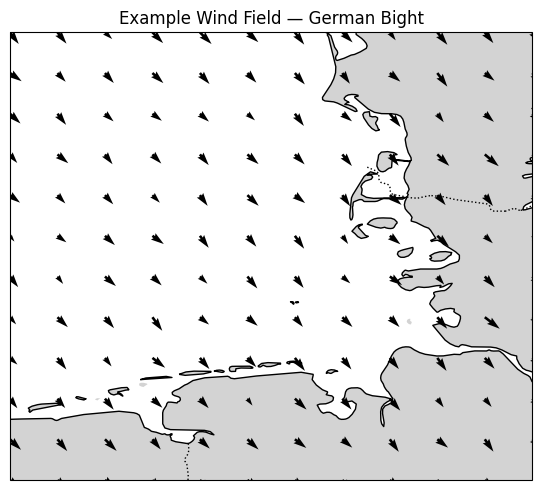

In [10]:
print("=== SYMBOLIC INPUT ===")
print(summaries[0])
print("\n=== TARGET TEXT ===")
print(texts[0])

LON, LAT, U, V = fields[0]
plot_wind_field(LON, LAT, U, V, "Example Wind Field — German Bight")

In [13]:
# ============================================================================
# Train a text-to-text Transformer (T5) on symbolic wind summaries
#
# What happens in this cell:
# 1. Load a pretrained T5-small model and tokenizer
# 2. Fine-tune the model to map:
#       symbolic spatial wind summaries  -->  natural-language descriptions
# 3. Use standard teacher forcing with cross-entropy loss
#
# Notes for the lecture:
# - This is NOT yet true multimodal learning.
# - The model only sees *text*, but the text encodes spatial structure.
# - This is a deliberate, simplified stepping stone toward multimodal models.
# ============================================================================

# --- Silence non-essential library warnings (for clean notebook output) ---
import warnings
warnings.filterwarnings("ignore")   # hide FutureWarning, UserWarning, etc.

# --- Load tokenizer and model ---
# We explicitly keep legacy=True to ensure stable, backward-compatible behavior.
from transformers import T5Tokenizer, T5ForConditionalGeneration

tokenizer = T5Tokenizer.from_pretrained(
    "t5-small",
    legacy=True          # explicit: avoids repeated legacy warning
)

model = T5ForConditionalGeneration.from_pretrained(
    "t5-small"
).to(device)

# --- Optimizer ---
# AdamW is the standard choice for Transformer fine-tuning
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

# --- Training loop ---
num_epochs = 15

for epoch in range(num_epochs):
    loss_sum = 0.0

    # Loop over all training samples
    for summary_text, target_text in zip(summaries, texts):

        # Encode symbolic wind summary (input sequence)
        input_ids = tokenizer.encode(
            summary_text,
            return_tensors="pt",
            max_length=256,
            truncation=True
        ).to(device)

        # Encode reference weather description (target sequence)
        labels = tokenizer.encode(
            target_text,
            return_tensors="pt",
            max_length=64,
            truncation=True
        ).to(device)

        # Forward pass:
        # - T5 internally performs teacher forcing
        # - Loss = cross-entropy between generated tokens and target tokens
        outputs = model(input_ids=input_ids, labels=labels)
        loss = outputs.loss

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()

    # Average loss over the dataset
    avg_loss = loss_sum / len(texts)
    print(f"Epoch {epoch+1:02d}/{num_epochs} | Mean loss: {avg_loss:.4f}")

Epoch 01/15 | Mean loss: 1.1197
Epoch 02/15 | Mean loss: 0.0347
Epoch 03/15 | Mean loss: 0.0243
Epoch 04/15 | Mean loss: 0.0196
Epoch 05/15 | Mean loss: 0.0147
Epoch 06/15 | Mean loss: 0.0107
Epoch 07/15 | Mean loss: 0.0093
Epoch 08/15 | Mean loss: 0.0073
Epoch 09/15 | Mean loss: 0.0074
Epoch 10/15 | Mean loss: 0.0062
Epoch 11/15 | Mean loss: 0.0053
Epoch 12/15 | Mean loss: 0.0055
Epoch 13/15 | Mean loss: 0.0038
Epoch 14/15 | Mean loss: 0.0027
Epoch 15/15 | Mean loss: 0.0020


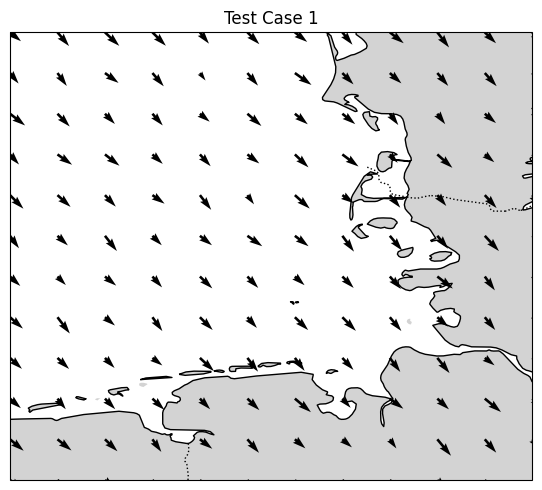

Northwesterly winds over the German Bight with moderate intensity and
speeds around 10 m/s.
------------------------------------------------------------


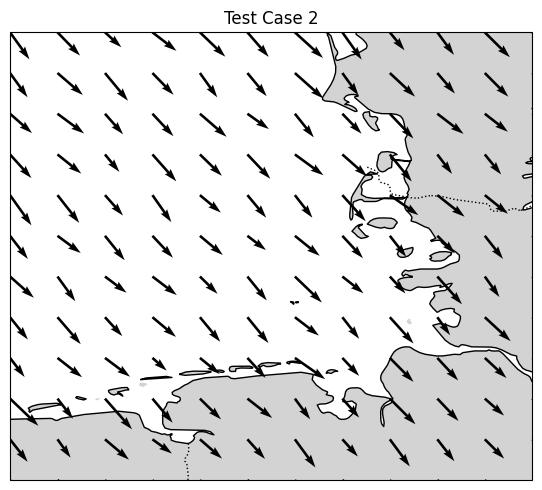

Northwesterly winds over the German Bight with strong intensity and
speeds around 20 m/s.
------------------------------------------------------------


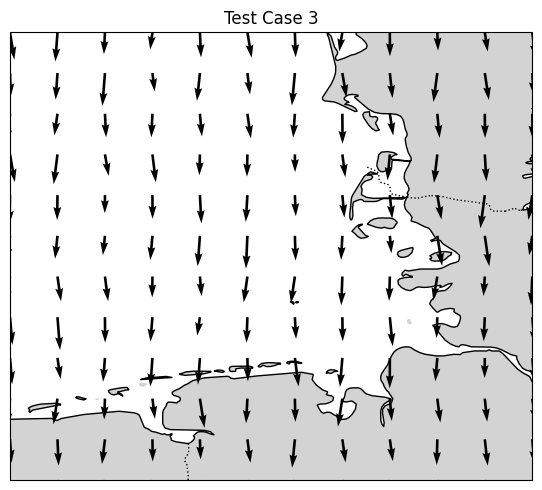

Northwesterly winds over the German Bight with strong intensity and
speeds around 15 m/s.
------------------------------------------------------------


In [14]:
def generate_forecast(summary):
    ids = tokenizer.encode(summary, return_tensors="pt").to(device)
    out = model.generate(ids, max_length=60)
    return tokenizer.decode(out[0], skip_special_tokens=True)


for i in range(3):
    LON, LAT, U, V, speed, theta = generate_wind_field(
        base_dir_deg=random.choice([270, 315, 0]),
        base_speed=random.uniform(8, 22),
    )

    summary = encode_wind_symbolic(speed, theta)
    forecast = generate_forecast(summary)

    plot_wind_field(LON, LAT, U, V, f"Test Case {i+1}")
    print(textwrap.fill(forecast, 70))
    print("-" * 60)